In [1]:
from databases.db_models import DBPost
from databases.external import DBConfig, SQliteConnection
from databases.platform_db_mgmt import PlatformDB
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from src.const import BASE_DATA_PATH

# old..
platform_db = PlatformDB("twitter", DBConfig(db_connection=SQliteConnection(db_path=BASE_DATA_PATH / "twitter.sqlite")))
db = platform_db.db_mgmt

# todo use misc.helper
def get_posts(platform: str,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()


2025-01-15 07:46:49,202 - ...Databases.databases.db_mgmt - DEBUG - creating db engine with sqlite:////home/rsoleyma/projects/platforms-clients/data/twitter.sqlite


In [2]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("twitter",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts


get_year_counts(2023)

2023-01-01    120
2023-01-02    120
2023-01-03    120
2023-01-04    120
2023-01-05    120
             ... 
2023-05-05     72
2023-05-06     72
2023-05-07     72
2023-05-08     72
2023-05-09     30
Length: 129, dtype: int64

In [3]:
import matplotlib.dates as mdates


def plot_daily_items(daily_counts: pd.Series):
    plt.figure(figsize=(12, 6))

    # Convert index to datetime if not already
    if not isinstance(daily_counts.index, pd.DatetimeIndex):
        daily_counts.index = pd.to_datetime(daily_counts.index)

    sns.lineplot(data=daily_counts, color='blue', label='Posts')

    # Zero days highlight
    zero_days = daily_counts[daily_counts == 0]
    if not zero_days.empty:
        plt.scatter(zero_days.index, zero_days.values,
                    color='red', s=10, label='No Posts',
                    zorder=5)

    plt.title('Daily Post Count (Red Dots = No Posts)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')

    # Improved x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    return plt


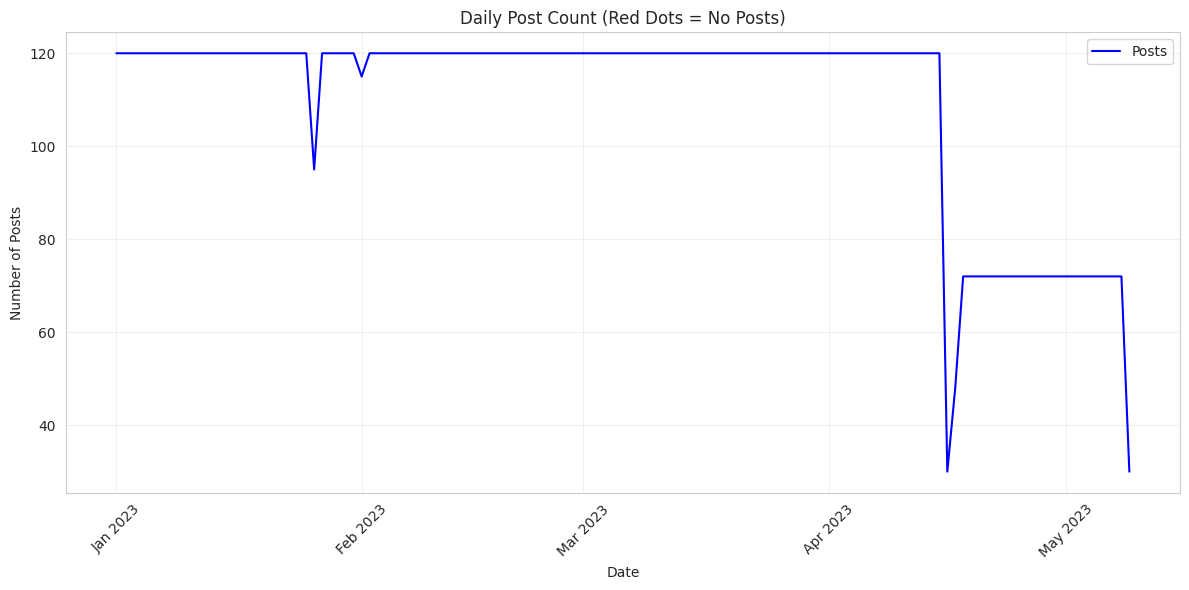

In [4]:
yc_2023 = get_year_counts(2023)
plot = plot_daily_items(yc_2023)
plot.show()

/tmp/ipykernel_30670/2275839549.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


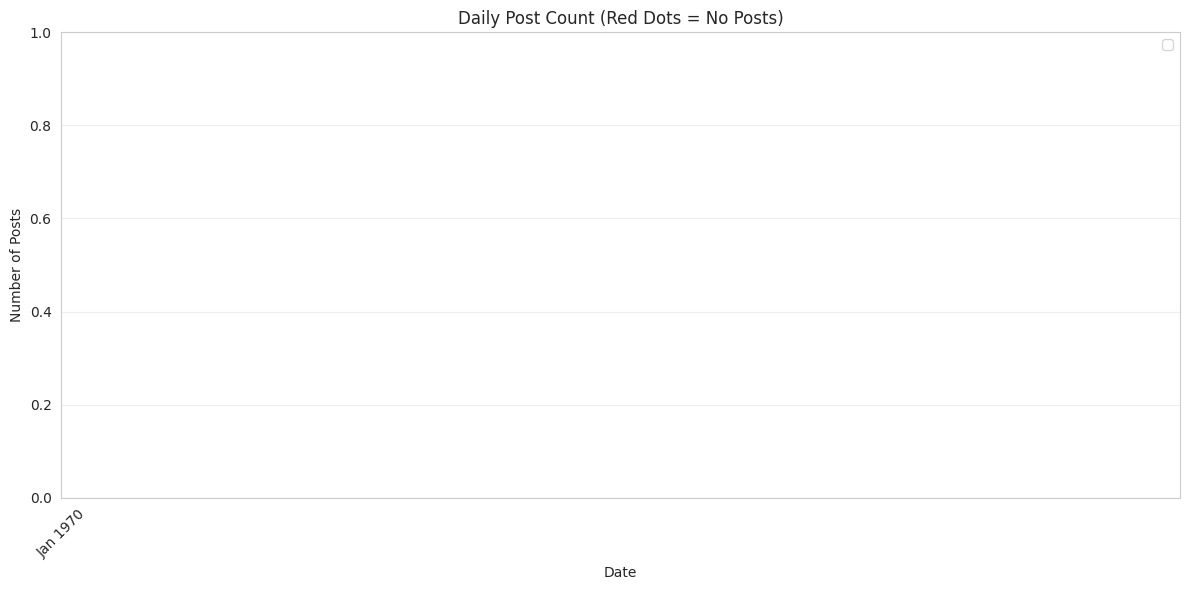

/tmp/ipykernel_30670/2275839549.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


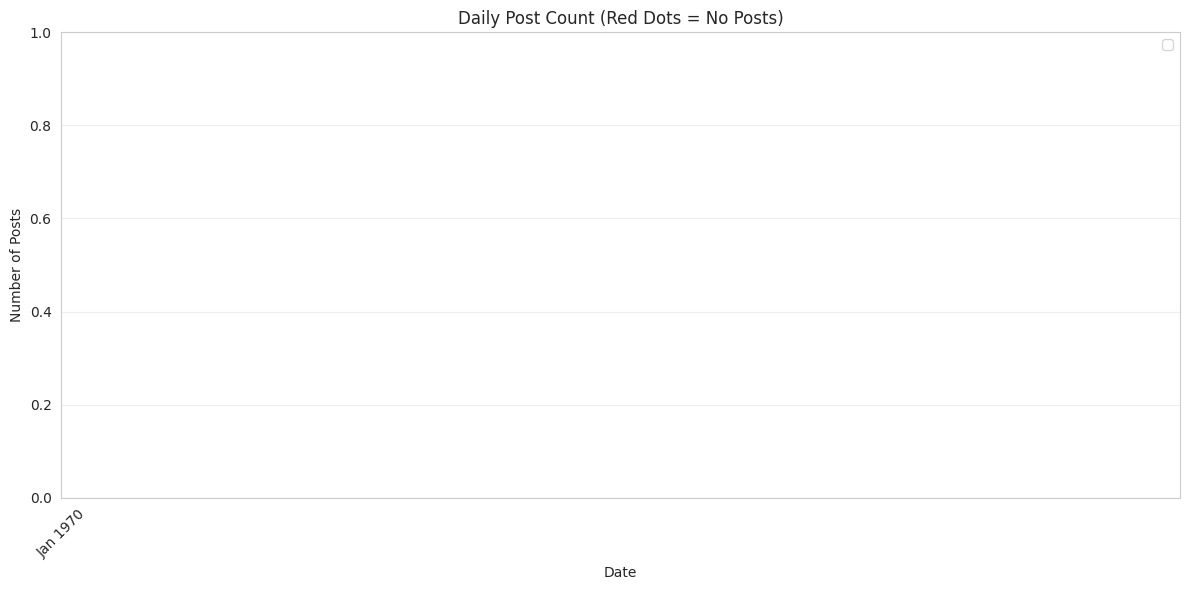

In [5]:

yc_2022 = get_year_counts(2022)
plot = plot_daily_items(yc_2022)
plot.show()
yc_2023 = get_year_counts(2023)
plot = plot_daily_items(yc_2023)
plot.show()

In [8]:
from databases.db_models import DBCollectionTask
from sqlalchemy.orm import contains_eager


# todo use misc.helper
def get_posts_w_task(platform: str,
                     conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
                     ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(DBPost, DBCollectionTask).join(
            DBCollectionTask,
            DBPost.collection_task_id == DBCollectionTask.id
        ).options(
            contains_eager(DBPost.collection_task)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        res = session.execute(query).all()
        return [(post.model(), post_col_task.model()) for post, post_col_task in res]


jan_2022 = get_posts_w_task("youtube", conditions=DBPost.date_created.between(
    datetime(2022, 1, 1),
    datetime(2022, 2, 1)
))

In [16]:
# for post, post_col in jan_2022:
#     print(post_col.collection_config)

len(jan_2022), len([_ for _, post_col in jan_2022 if post_col.collection_config.get("location")])

(3327, 2616)